In [1]:
import os
import argparse
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


def find_file(root: Path, candidates):
    for name in candidates:
        for p in root.rglob(name):
            return p
    return None


def load_csv(path):
    return pd.read_csv(path, parse_dates=["Date"], infer_datetime_format=True)


def main(news_path=None, prices_path=None, out_dir="eda_output"):
    # __file__ n'existe pas dans un notebook -> fallback vers le cwd ou recherche du repo (.git / dossier Project)
    try:
        project_root = Path(__file__).resolve().parents[1]  # repo/Project
    except NameError:
        cwd = Path.cwd()
        project_root = None
        for p in [cwd] + list(cwd.parents):
            if (p / ".git").exists() or p.name.lower() == "project":
                project_root = p
                break
        if project_root is None:
            project_root = cwd

    if news_path is None:
        news_path = find_file(project_root, ["Combined_News_DJIA.csv", "*Combined*.csv", "*news*.csv"])
    if prices_path is None:
        prices_path = find_file(project_root, ["DJIA_table.csv", "*DJIA*.csv", "*prices*.csv", "*Dow*.csv"])

    if news_path is None or prices_path is None:
        print("Fichiers introuvables. Placez Combined_News_DJIA.csv et le fichier prix (DJIA) dans le projet")
        print("Ou passez --news et --prices avec les chemins complets.")
        return

    news_path = Path(news_path)
    prices_path = Path(prices_path)
    print("News file:", news_path)
    print("Prices file:", prices_path)

    news = load_csv(news_path)
    prices = load_csv(prices_path)

    os.makedirs(out_dir, exist_ok=True)

    # --- Inspect basic info
    print("\n--- NEWS: shape, cols ---")
    print(news.shape)
    print(news.columns.tolist())
    print("\nNulls in news:")
    print(news.isna().sum())

    print("\n--- PRICES: shape, cols ---")
    print(prices.shape)
    print(prices.columns.tolist())
    print("\nNulls in prices:")
    print(prices.isna().sum())

    # Ensure Date align & sort
    news = news.sort_values("Date").reset_index(drop=True)
    prices = prices.sort_values("Date").reset_index(drop=True)

    # Merge if possible
    merged = pd.merge(news, prices, on="Date", how="inner")
    print(f"\nMerged rows: {len(merged)} (inner join)")

    # Label distribution (Combined_News_DJIA has a 'Label' column)
    if "Label" in news.columns:
        print("\nLabel distribution (news dataset):")
        print(news["Label"].value_counts(dropna=False))
        fig, ax = plt.subplots(figsize=(5, 3))
        news["Label"].value_counts().plot(kind="bar", ax=ax, title="Label distribution")
        fig.tight_layout()
        fig.savefig(Path(out_dir) / "label_distribution.png")
    else:
        print("Aucune colonne 'Label' trouvée dans news.")

    # Headlines: identify headline columns (usually Top1..Top25)
    headline_cols = [c for c in news.columns if c.lower().startswith("top") or "headline" in c.lower()]
    print("\nDetected headline columns:", headline_cols)

    # Combine headlines into one text and compute lengths
    def concat_headlines(row):
        texts = [str(row[c]) for c in headline_cols if pd.notna(row.get(c))]
        return " ||| ".join(texts)

    if headline_cols:
        news["combined_text"] = news.apply(concat_headlines, axis=1)
        news["num_headlines"] = news[headline_cols].notna().sum(axis=1)
        news["avg_headline_len"] = news[headline_cols].apply(
            lambda r: np.mean([len(str(x).split()) for x in r.dropna()]) if r.dropna().shape[0] > 0 else 0, axis=1
        )
        # Basic stats
        print("\nHeadline stats (num_headlines / avg_headline_len):")
        print(news[["num_headlines", "avg_headline_len"]].describe())

        # Plots
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.histplot(news["num_headlines"], bins=15, ax=axes[0])
        axes[0].set_title("Distribution du nombre de titres par jour")
        sns.histplot(news["avg_headline_len"], bins=20, ax=axes[1])
        axes[1].set_title("Distribution longueur moyenne des titres (mots)")
        fig.tight_layout()
        fig.savefig(Path(out_dir) / "headlines_stats.png")

    # Compute returns & direction from prices (assume 'Close' column exists)
    if "Close" in prices.columns:
        prices["ret"] = prices["Close"].pct_change()
        prices["next_ret"] = prices["ret"].shift(-1)
        prices["next_dir"] = (prices["next_ret"] > 0).astype(int)
        print("\nPrices returns preview:")
        print(prices[["Date", "Close", "ret", "next_ret", "next_dir"]].head())

        # Merge with news: merged already exists; if not present compute
        merged = pd.merge(news, prices[["Date", "Close", "ret", "next_ret", "next_dir"]], on="Date", how="inner")
        # If dataset Label exists, compute simple agreement with next_dir
        if "Label" in merged.columns:
            merged["Label_bin"] = merged["Label"].astype(int)
            agreement = merged[["Label_bin", "next_dir"]].dropna()
            corr = agreement["Label_bin"].corr(agreement["next_dir"])
            print(f"\nCorrelation Label <-> next day direction: {corr:.4f}")
            confusion = pd.crosstab(agreement["Label_bin"], agreement["next_dir"], rownames=["Label"], colnames=["next_dir"])
            print("\nConfusion table (Label vs next day direction):")
            print(confusion)
            # Save confusion
            confusion.to_csv(Path(out_dir) / "confusion_label_vs_nextdir.csv")
    else:
        print("Aucune colonne 'Close' trouvée dans les prix ; impossible de calculer retours.")

    # Save a small merged sample and basic stats
    merged.head(200).to_csv(Path(out_dir) / "merged_sample.csv", index=False)
    with open(Path(out_dir) / "summary.txt", "w", encoding="utf8") as f:
        f.write("EDA summary\n\n")
        f.write(f"news rows: {len(news)}\n")
        f.write(f"prices rows: {len(prices)}\n")
        f.write(f"merged rows: {len(merged)}\n")
        if "Label" in news.columns:
            f.write("\nLabel value counts:\n")
            f.write(news["Label"].value_counts(dropna=False).to_string())
        if "Close" in prices.columns:
            f.write("\n\nPrice columns:\n")
            f.write(", ".join(prices.columns))
    print("\nEDA complete. Résultats sauvegardés dans:", out_dir)


if __name__ == "__main__":
    import sys
    p = argparse.ArgumentParser(description="EDA for Combined_News_DJIA + prices")
    p.add_argument("--news", type=str, default=None, help="Path to Combined_News_DJIA.csv")
    p.add_argument("--prices", type=str, default=None, help="Path to prices CSV (DJIA_table)")
    p.add_argument("--out", type=str, default="eda_output", help="Output folder for images/csv")

    # Use parse_known_args to ignore kernel/unknown args (works in Jupyter)
    args, _ = p.parse_known_args()
    # If running inside notebook without args, vous pouvez appeler main() manuellement avec des chemins
    main(args.news, args.prices, args.out)

Fichiers introuvables. Placez Combined_News_DJIA.csv et le fichier prix (DJIA) dans le projet
Ou passez --news et --prices avec les chemins complets.


News file: C:\Users\User\Documents\M2 FMGR\info\data\Combined_News_DJIA.csv
Prices file: C:\Users\User\Documents\M2 FMGR\info\data\DJIA_table.csv

--- NEWS: shape, cols ---
(1989, 27)
['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25']

Nulls in news:
Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

--- PRICES: shape, cols ---
(1989, 7)
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

Nulls in prices:
Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

Merged rows: 198

C:\Users\User\AppData\Local\Temp\ipykernel_20372\2307384452.py:22: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(path, parse_dates=["Date"], infer_datetime_format=True)
C:\Users\User\AppData\Local\Temp\ipykernel_20372\2307384452.py:22: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(path, parse_dates=["Date"], infer_datetime_format=True)



Detected headline columns: ['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25']

Headline stats (num_headlines / avg_headline_len):
       num_headlines  avg_headline_len
count    1989.000000       1989.000000
mean       24.996481         17.702627
std         0.092406          2.888500
min        22.000000          8.840000
25%        25.000000         15.840000
50%        25.000000         17.720000
75%        25.000000         19.680000
max        25.000000         28.800000


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Prices returns preview:
        Date         Close       ret  next_ret  next_dir
0 2008-08-08  11734.320312       NaN  0.004093         1
1 2008-08-11  11782.349609  0.004093 -0.011872         0
2 2008-08-12  11642.469727 -0.011872 -0.009406         0
3 2008-08-13  11532.959961 -0.009406  0.007194         1
4 2008-08-14  11615.929688  0.007194  0.003785         1

Correlation Label <-> next day direction: -0.0510

Confusion table (Label vs next day direction):
next_dir    0    1
Label             
0         404  520
1         520  545

EDA complete. Résultats sauvegardés dans: eda_output


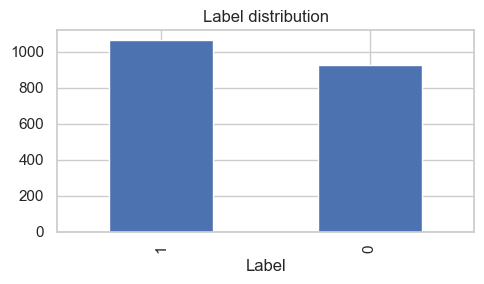

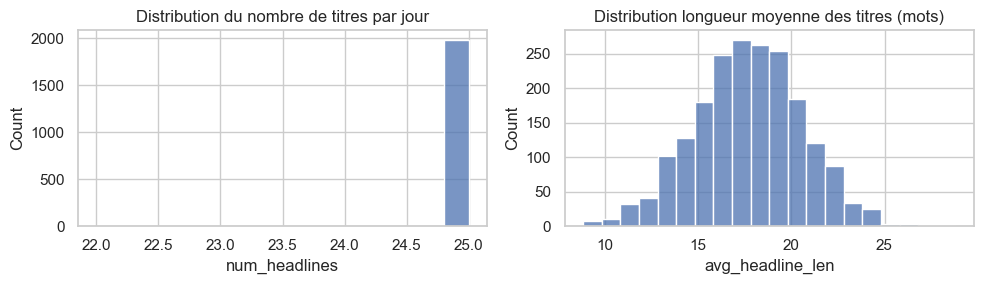

In [2]:
# Exécutez dans une nouvelle cellule du notebook
main(
    news_path=r"C:\Users\User\Documents\M2 FMGR\info\data\Combined_News_DJIA.csv",
    prices_path=r"C:\Users\User\Documents\M2 FMGR\info\data\DJIA_table.csv",
    out_dir="eda_output"
)